# Classifying

This notebook tests a number of classification algorithms to determine if it is possible to classify census tracts into their respective clusters, where the clusters were created by using the change in values from the 2000 census to the 2010 census.

In [212]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [213]:
# import the csv that has the clusters assigned to each tract
df = pd.read_csv('cluster.csv')
df.head()

,tractid,cluster,INCPC00_PC,MHMVAL00_PC,MRENT00_PC,percent_4yrcollege_degree_ormore_PC,percent_employed_PC,percent_professional_PC,percent_poverty_PC,percent_multiunit_houses_PC,POP00_PC,percent_non-white00_PC
0,25025000100,1,25.296604,56.776227,50.111359,-24.905530,-1.512466,-46.293279,8.883061,-7.958695,7.207661,27.326426
1,25025000201,1,37.770551,100.301205,41.775984,12.614115,0.335627,-6.840674,16.479972,3.052451,-0.848984,22.631076
2,25025000202,1,24.108126,56.414890,58.414634,11.102718,-6.166663,-4.263648,49.255236,-1.722674,-1.019108,2.145146
3,25025000301,0,68.358748,91.091418,51.287333,37.542492,-1.048579,19.626072,0.051206,-3.128630,-6.260691,45.576692
4,25025000302,1,0.034080,24.161852,15.713135,-1.157077,0.924476,-5.207653,200.725668,-7.814990,7.991676,32.146323


In [214]:
# subset tracts and clusters
df=df.iloc[:,0:2]

In [215]:
# import the data from the 2000 census 
df2 = pd.read_csv('Final_2000_data.csv',index_col=0)

In [216]:
# join the dataframes
df = df.merge(df2,how='inner',on='tractid')

In [217]:
df.set_index('tractid',inplace=True)

In [269]:
# split into X and Y
X = df[['POP00','percent_white00', 'percent_black00', 'percent_asian00',
       'percent_hispanic00', 'percent_indian00', 'percent_chinese00',
       'percent_filip00', 'percent_japan00', 'percent_korean00',
       'percent_viet00', 'percent_mex00', 'percent_pr00', 'percent_cuban00',
       'percent_vacant_housing00', 'percent_occupied_housing00',
       'percent_under18_00', 'percent_60andup_00', 'percent_75andup_00',
       'percent_owneroccupied_00', 'percent_renteroccupied_00',
       'percent_non-white00']]
Y = df['cluster']
Y=Y.astype('str')

# Dummy Classifier

In [249]:

dummy_clf = DummyClassifier('most_frequent')

In [275]:
def stratified_k_fold(model_object,n_splits,df,y):
    skf = StratifiedKFold(n_splits=n_splits)
    test_scores = []
    train_scores = []
    for i in range(n_splits):
        result=next(skf.split(df,y))
        x_train=df.iloc[result[0]]
        x_test=df.iloc[result[1]]
        y_train=y.iloc[result[0]]
        y_test=y.iloc[result[1]]
        model=model_object.fit(x_train,y_train)
        y_hat_train=model_object.predict(x_train)
        y_hat_test=model_object.predict(x_test)
        test_score = accuracy_score(y_hat_test,y_test)
        train_score= accuracy_score(y_hat_train,y_train)
        test_scores.append(test_score)
        train_scores.append(train_score)
    return f'Train scores from each iteration:{train_scores}',f'Average K-Fold train score: {np.mean(train_scores)}',f'Test scores from each iteration:{test_scores}',f'Average K-Fold test score: {np.mean(test_scores)}'

In [276]:
stratified_k_fold(dummy_clf,5,X,Y)

('Train scores from each iteration:[0.38190954773869346, 0.38190954773869346, 0.38190954773869346, 0.38190954773869346, 0.38190954773869346]',
 'Average K-Fold train score: 0.38190954773869346',
 'Test scores from each iteration:[0.37735849056603776, 0.37735849056603776, 0.37735849056603776, 0.37735849056603776, 0.37735849056603776]',
 'Average K-Fold test score: 0.37735849056603776')

## Logistic Regression

In [199]:
logreg = LogisticRegression(fit_intercept = False, solver='newton-cg')
logreg.fit(X_train, y_train)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [200]:
y_hat_train_log = logreg.predict(X_train)
y_hat_test_log = logreg.predict(X_test)

In [201]:
print(accuracy_score(y_hat_train_log,y_train))
print(accuracy_score(y_hat_test_log,y_test))

0.5472636815920398
0.3333333333333333


Normalized confusion matrix
[[0.71428571 0.21428571 0.07142857 0.        ]
 [0.54545455 0.31818182 0.09090909 0.04545455]
 [0.28571429 0.71428571 0.         0.        ]
 [0.25       0.5        0.25       0.        ]]


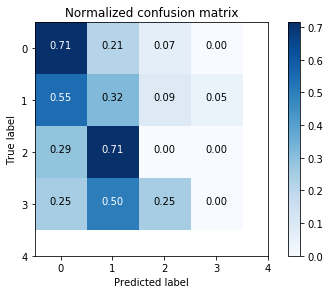

In [205]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test_log)
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,classes=[0,1,2,3,4],
                      title='Normalized confusion matrix')
plt.show()


In [192]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('confusion')

In [184]:
def plot_AUC_ROC(y_score,fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()